In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout, GRU, Bidirectional, SimpleRNN
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# import pygame as pg
from visualisers.pg_visualiser import py_visualiser


pygame 2.2.0 (SDL 2.0.22, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Constants

In [2]:
train_size = 0.8
rng = np.random.default_rng(2048)
n_epochs = 1000
batch_size = None
len_seq = 2
spacial_dim = 2
n_hidden = 32
test_indx = 1

In [3]:
def prep_data():
    # Reading data
    dataset = pd.read_csv('csvs/spiral.csv', header=0)
    dataset = dataset.iloc[::15]
    # eliminate all white spaces from the column names
    dataset.columns = dataset.columns.str.replace(' ', '')
    # print(dataset.shape)

    # Scale the entire DataFrame
    scaler = MinMaxScaler()
    # pos_col = ['x','y','z']
    scaled_data = scaler.fit_transform(dataset[['x','y']])
    # print(scaled_data)

    # Convert the scaled data back to a DataFrame
    dataset[['x','y']] = scaled_data
    # print(dataset.shape)
        
    # format
    input_len = len(dataset[dataset['particle']==0])-len_seq
    inputs = np.zeros((10,input_len, len_seq, spacial_dim)) # ILDC
    targets = np.zeros((10,input_len, spacial_dim))

    for i in range(10):
        particle_data = dataset[dataset['particle'] == i]
        
        particle_data = particle_data.drop(['t', 'particle'], axis=1)
        
        for j in range(len(particle_data)-len_seq):
            inputs[i][j] = particle_data.iloc[j:j+len_seq]
            targets[i][j] = particle_data.iloc[j+len_seq]
            
   

    return dataset, inputs, targets

In [4]:
raw_data, inputs, targets = prep_data()
inputs[-1]


array([[[0.44941344, 0.32615373],
        [0.44970799, 0.32558993]],

       [[0.44970799, 0.32558993],
        [0.45001249, 0.32502863]],

       [[0.45001249, 0.32502863],
        [0.45032693, 0.32446998]],

       ...,

       [[0.00490001, 0.35027584],
        [0.00351725, 0.34354806]],

       [[0.00351725, 0.34354806],
        [0.00223905, 0.33678137]],

       [[0.00223905, 0.33678137],
        [0.00106633, 0.32997713]]])

In [5]:
# combined all the points,,, again
sequences_train_inputs, sequenced_test_inputs = inputs[:int(train_size*len(inputs))], inputs[int(train_size*len(inputs)):]
sequenced_train_targets, sequenced_test_targets = targets[:int(train_size*len(inputs))], targets[int(train_size*len(inputs)):]

train_inputs, test_inputs = sequences_train_inputs.reshape(-1, len_seq, spacial_dim), sequenced_test_inputs.reshape(-1, len_seq, spacial_dim)
train_targets, test_targets = sequenced_train_targets.reshape(-1,spacial_dim), sequenced_test_targets.reshape(-1,spacial_dim)
# train_inputs.shape, train_targets.shape
# print(sequences_train_inputs), test_targets.shape


## The rnn


In [6]:
def build_rnn(n_hidden=32, n_layers=1, input_shape = (2,spacial_dim)):

    '''
        inputs:
        input_shape: (n_timesteps, input_dim)'''
    model = Sequential()
    for _ in range(n_layers):
        model.add(LSTM(n_hidden, input_shape=input_shape))

    model.add(Dense(spacial_dim))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


model = build_rnn(n_hidden)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [7]:
# drop time and particle label
type(train_inputs) 
type(train_targets)
# tf.convert_to_tensor(train_inputs)
model.fit(train_inputs, train_targets, epochs=n_epochs, batch_size=batch_size)

Epoch 1/1000


2023-05-14 18:49:13.664261: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


200/200 [==============================] - 3s 7ms/step - loss: 0.0378
Epoch 2/1000
200/200 [==============================] - 2s 8ms/step - loss: 0.0017
Epoch 3/1000
200/200 [==============================] - 2s 8ms/step - loss: 3.4835e-04
Epoch 4/1000
200/200 [==============================] - 2s 9ms/step - loss: 1.2575e-04
Epoch 5/1000
200/200 [==============================] - 2s 9ms/step - loss: 8.8691e-05
Epoch 6/1000
200/200 [==============================] - 1s 7ms/step - loss: 7.5613e-05
Epoch 7/1000
200/200 [==============================] - 1s 7ms/step - loss: 6.4061e-05
Epoch 8/1000
200/200 [==============================] - 1s 7ms/step - loss: 5.3856e-05
Epoch 9/1000
200/200 [==============================] - 1s 7ms/step - loss: 4.4557e-05
Epoch 10/1000
200/200 [==============================] - 2s 8ms/step - loss: 3.6686e-05
Epoch 11/1000
200/200 [==============================] - 1s 7ms/step - loss: 3.0249e-05
Epoch 12/1000
200/200 [==============================] - 1s 7m

KeyboardInterrupt: 

In [ ]:
# model = load_model('multi_1000_32.h5')

In [ ]:
def test_rnn(model, sequenced_test_inputs, seq_indx=0):
    # Make predictions for each time step
    predicted_sequence = []
    current_step = sequenced_test_inputs[seq_indx][0].reshape(-1,len_seq,spacial_dim) # Initialize the current 2 step with the input data
    print(current_step.shape)
    for i in range(len(sequenced_test_inputs[0])):
        

        predicted_step = model.predict(current_step)
        predicted_sequence.append(predicted_step)
        # Update the current step by shifting the window
        current_step = np.concatenate([current_step[:, 1:, :], predicted_step.reshape(1,1,spacial_dim)], axis=1)

    predicted_sequence = np.array(predicted_sequence)

    # processed_sequence = write_result(predicted_sequence)

    return predicted_sequence


pred_seq = test_rnn(model, sequenced_test_inputs, test_indx)

(1, 2, 2)
1/1 [==============================] - 0s 12ms/step


In [ ]:
model.save('trained_models/spiral_800.h5')


## Visualisation

In [ ]:
# separate x,y,z

pred_seq = pred_seq.reshape(-1,spacial_dim)


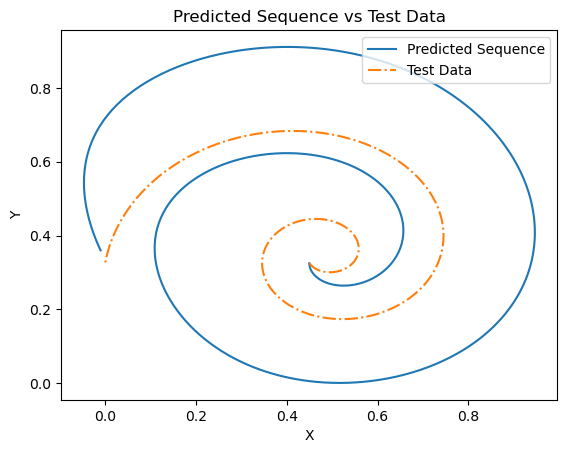

In [ ]:


# Extract x, y, z coordinates from predicted sequence
pred_x = pred_seq[:, 0]
pred_y = pred_seq[:, 1]
# pred_z = pred_seq[:, 2]

# Extract x, y, z coordinates from test data
test_x = sequenced_test_targets[test_indx][:, 0]
test_y = sequenced_test_targets[test_indx][:, 1]
# test_z = sequenced_test_targets[test_indx][:, 2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the predicted sequence
ax.plot(pred_x, pred_y,label='Predicted Sequence')

# Plot the test data
ax.plot(test_x, test_y, label='Test Data', linestyle='-.')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.set_title('Predicted Sequence vs Test Data')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# pg vis

py_visualiser(dataset=raw_data, seq_pos=pred_seq)
